In [116]:
import numpy as np

with np.load('dimredux-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    validation_x = fh['validation_x']
    validation_y = fh['validation_y']

# TRAINING DATA:
print(data_x.shape, data_x.dtype)

# VALIDATION DATA:
print(validation_x.shape, validation_x.dtype)
print(validation_y.shape, validation_y.dtype)

(100000, 3) float64
(1000, 3) float64
(1000,) int32


In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torchvision


In [118]:
def mean_free(data):
    means = data.sum(axis = 0)/data.shape[0]
    mean_free_data = data-means
    return mean_free_data, means




def whiten_data(data):
    cov_matrix = np.cov(data.T)
    sigma,U = np.linalg.eig(cov_matrix)
    white_data = np.dot(np.dot(data,U),np.diag(1/(sigma**0.5)))
    return white_data, cov_matrix


Make data mean-free

In [119]:
T = data_x.shape[0]
tau = 1
X = data_x[:-tau]
Y = data_x[tau:]

In [120]:
X[1]

array([-10.57155779,  15.7079958 ,  10.53458138])

In [121]:
Y[0]

array([-10.57155779,  15.7079958 ,  10.53458138])

In [122]:
Tv = validation_x.shape[0]
test_X = validation_x[:-tau]
test_Y = validation_x[tau:]

test_X, _ = mean_free(test_X)
test_Y,_  = mean_free(test_Y)
white_X_test, c_xx_test =  whiten_data(test_X)
white_Y_test, c_yy_test =  whiten_data(test_Y)


Make data Mean-free

In [123]:
X, x_means = mean_free(X)
Y, y_means  = mean_free(Y)

Compute covariance matrices and whiten data

In [124]:

white_X, c_xx =  whiten_data(X)
white_Y, c_yy =  whiten_data(Y)


In [125]:
batch_size = 100
training_data=TensorDataset(torch.tensor(white_X),torch.tensor(white_Y))
train_loader = torch.utils.data.DataLoader(training_data, batch_size)

validating_data = TensorDataset(torch.tensor(white_X_test),torch.tensor(white_Y_test))
test_loader = torch.utils.data.DataLoader(validating_data, batch_size)

In [126]:
class Autoencoder(nn.Module):
    def __init__(self, inp_size=3, lat_size=1, dropout=0.5,bias=True,  cuda=False):
        super(Autoencoder, self).__init__()
        self.input_dim = inp_size
        self.latent_dim = lat_size
        self.d_coef = dropout

        if cuda:
            self.use_cuda = True
            self.cuda() 
        else:
            self.use_cuda = False

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(128,self.latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(256, self.input_dim)
        )
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
print(device)
model = Autoencoder(inp_size=).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

losses = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, future_data) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        K = model(data.float())
        loss = criterion(K, future_data.float())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            losses.append(loss / len(data))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, future_data) in enumerate(test_loader):
            data = data.to(device)
            K = model(data.float())
            test_loss += criterion(K, future_data.float()).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

            

cpu


In [128]:
for epoch in range(1, 10):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/99999 (0%)]	Loss: 0.014878
Train Epoch: 1 [10000/99999 (10%)]	Loss: 0.010463
Train Epoch: 1 [20000/99999 (20%)]	Loss: 0.005807
Train Epoch: 1 [30000/99999 (30%)]	Loss: 0.008642
Train Epoch: 1 [40000/99999 (40%)]	Loss: 0.006691
Train Epoch: 1 [50000/99999 (50%)]	Loss: 0.008869
Train Epoch: 1 [60000/99999 (60%)]	Loss: 0.005616
Train Epoch: 1 [70000/99999 (70%)]	Loss: 0.008601
Train Epoch: 1 [80000/99999 (80%)]	Loss: 0.010415
Train Epoch: 1 [90000/99999 (90%)]	Loss: 0.008208
====> Epoch: 1 Average loss: 0.0077
====> Test set loss: 0.0069
Train Epoch: 2 [0/99999 (0%)]	Loss: 0.010558
Train Epoch: 2 [10000/99999 (10%)]	Loss: 0.010087
Train Epoch: 2 [20000/99999 (20%)]	Loss: 0.005240
Train Epoch: 2 [30000/99999 (30%)]	Loss: 0.008543
Train Epoch: 2 [40000/99999 (40%)]	Loss: 0.006217
Train Epoch: 2 [50000/99999 (50%)]	Loss: 0.008280
Train Epoch: 2 [60000/99999 (60%)]	Loss: 0.005135
Train Epoch: 2 [70000/99999 (70%)]	Loss: 0.008508
Train Epoch: 2 [80000/99999 (80%)]	Loss: 0.010

In [147]:
t,_ = mean_free(data_x)
t,_ = whiten_data(t)

with torch.no_grad():
    latent = model.encode(torch.tensor(t).float()).numpy()

In [148]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=4)
kmeans.fit(latent)
def predict(latent):
    return kmeans.predict(latent)


(100000,)

In [151]:
v,_ = mean_free(validation_x)
v,_ = whiten_data(v)

with torch.no_grad():
    latent = model.encode(torch.tensor(v).float()).numpy()
prediction_validation = predict(latent)
prediction_validation.shape

(1000,)

In [152]:
def accuracy(true, predicted):
    return np.sum(true == predicted)/len(true)

In [153]:
def validation_accuracy(my, validation_y):
    max_accuracy = 0
    clusters = np.array([0,1,2,3])
    my = np.where(my ==0, 10, my)
    my = np.where(my ==1, 11, my)
    my = np.where(my ==2, 12, my)
    my = np.where(my ==3, 13, my)
    for c0 in clusters:
        for c1 in clusters[clusters!=c0]:
            for c2 in clusters[(clusters!=c0)&(clusters!=c1)]:
                c3 = int(clusters[(clusters!=c0)&(clusters!=c1)&(clusters!=c2)])
                my_new = my.copy()
                my_new = np.where(my ==10, c0, my_new)
                my_new = np.where(my ==11, c1, my_new)
                my_new = np.where(my ==12, c2, my_new)
                my_new = np.where(my ==13, c3, my_new)
                accuracy_new = accuracy(validation_y,my_new)
                #print(c0,c1,c2,c3, accuracy_new)
                if accuracy_new > max_accuracy:
                    print(c0,c1,c2,c3, accuracy_new)
                    max_accuracy = accuracy_new
                    true_clusters = np.array([c0,c1,c2,c3])
    return true_clusters, max_accuracy, my_new

            
    

In [132]:
def validation_accuracy(my, validation_y):
    max_accuracy = accuracy_score(validation_y,my)
    clusters = np.array([0,1,2,3])
    my = np.where(my ==0, 10, my)
    my = np.where(my ==1, 11, my)
    my = np.where(my ==2, 12, my)
    my = np.where(my ==3, 13, my)
    true_clusters = clusters.copy()
    for c0 in clusters:
        for c1 in clusters[clusters!=c0]:
            for c2 in clusters[(clusters!=c0)&(clusters!=c1)]:
                c3 = int(clusters[(clusters!=c0)&(clusters!=c1)&(clusters!=c2)])
                my_new = my.copy()
                my_new = np.where(my ==10, c0, my_new)
                my_new = np.where(my ==11, c1, my_new)
                my_new = np.where(my ==12, c2, my_new)
                my_new = np.where(my ==13, c3, my_new)
                accuracy_new = accuracy_score(validation_y,my_new)
                print(my_new[0:100])
                print(c0,c1,c2,c3, accuracy_new)
                if accuracy_new > max_accuracy:
                    print(c0,c1,c2,c3, accuracy_new)
                    max_accuracy = accuracy_new
                    true_clusters = np.array([c0,c1,c2,c3])
    return true_clusters, max_accuracy

In [154]:
true_clusters, acc, prediction_validation_true_clusters = validation_accuracy(validation_y,prediction_validation)

0 1 2 3 0.497
0 2 1 3 0.983


In [ ]:
guess = np.abs(latent[:, 0, None] - np.array(cc).squeeze()[None, :]).argmin(axis=1)
perms = [np.sum(np.array(p)[dtraj] == guess) for p in itertools.permutations([1,2,3,0])]
percent = np.max(perms) * 100. / len(dtraj)
print("{:.4f}%".format(percent))

In [155]:
true_clusters,acc

(array([0, 2, 1, 3]), 0.983)

In [137]:
prediction_validation_true_clusters

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

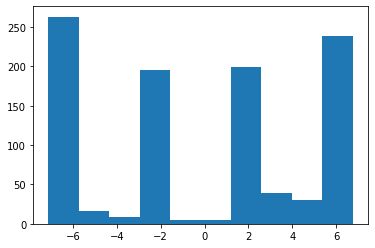

In [138]:
fig = plt.figure()
plt.hist(latent[:,0])
plt.show()

In [156]:
t,_ = mean_free(data_x)
t,_ = whiten_data(t)

with torch.no_grad():
    latent = model.encode(torch.tensor(t).float()).numpy()
prediction = predict(latent)
latent.shape

(100000, 1)

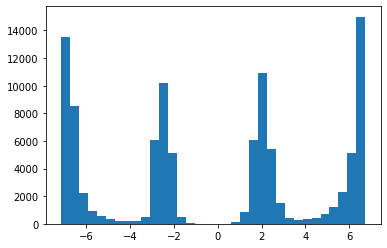

In [157]:
fig = plt.figure()
plt.hist(latent, bins='auto')
plt.show()

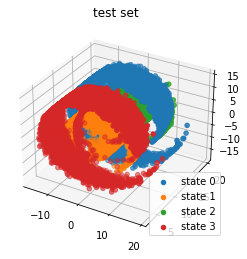

In [141]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in [0,1,2,3]:
    data = data_x[prediction == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.title('test set')
plt.show()

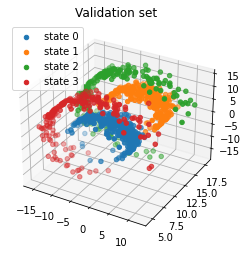

In [142]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(4):
    data = validation_x[validation_y == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.title('Validation set')
plt.show()

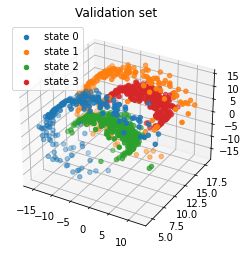

In [38]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(4):
    data = validation_x[prediction_validation == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.title('Validation set')
plt.show()

In [39]:
true_clusters

array([2, 3, 1, 0])

In [40]:
prediction_true = prediction.copy()
prediction_true = np.where(prediction_true ==0, 10, prediction_true)
prediction_true = np.where(prediction_true ==1, 11, prediction_true)
prediction_true = np.where(prediction_true ==2, 12, prediction_true)
prediction_true = np.where(prediction_true ==3, 13, prediction_true)

prediction_true = np.where(prediction_true ==10, true_clusters[0], prediction_true)
prediction_true = np.where(prediction_true ==11, true_clusters[1], prediction_true)
prediction_true = np.where(prediction_true ==12, true_clusters[2], prediction_true)
prediction_true = np.where(prediction_true ==13, true_clusters[3], prediction_true)


In [41]:
labels = np.argwhere(prediction_true!=3)


In [42]:
data = h[labels[:,0] == 0, :]
data

NameError: name 'h' is not defined

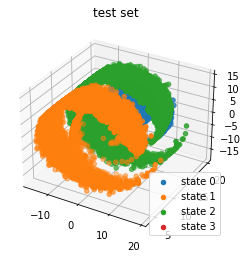

In [43]:
%matplotlib inline
h = data_x[prediction_true!=3]
labels = prediction_true[np.argwhere(prediction_true!=3)]

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(4):
    data = h[labels[:,0] == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.title('test set')
plt.show()

In [158]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 100000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (100000, )
    assert loaded.dtype == int
    assert (loaded <= 3).all()
    assert (loaded >= 0).all()
validate_prediction_format()

In [159]:
loaded = np.load('prediction.npy')

In [160]:
np.sum(prediction.astype(int)==loaded)

100000

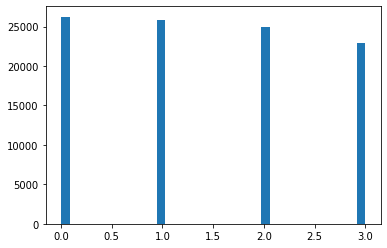

In [161]:
fig = plt.figure()
plt.hist(loaded, bins='auto')
plt.show()

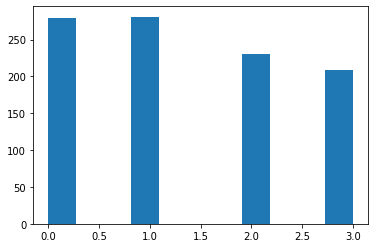

In [162]:

fig = plt.figure()
plt.hist(validation_y, bins='auto')
plt.show()